### LIBRARIES

In [1]:
# Data management
import pandas as pd
import numpy as np

# Graphs
import networkx as nx
import community
import igraph as ig
import leidenalg as la

# Plots
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Miscellaneous
from utils.utils import load_theme, cohesion_metrics, get_capital_gain_df, get_capital_gain_df_wagents
from tqdm import tqdm
import warnings
import ast
from collections import Counter

warnings.filterwarnings('ignore')

### DATASET

Main

In [2]:
df = pd.read_csv('dataset/transfers_complete.csv')
df = df[df["is_free"] == False]
df = df[df["is_loan"] == False]
df = df[df["is_loan_end"] == False]
df = df[df["is_retired"] == False]
df = df[df["counter_team_name"] != "Without Club"]
transfers = df[['team_name', 'counter_team_name', 'transfer_fee_amnt']]
transfers.head(5)

,team_name,counter_team_name,transfer_fee_amnt
0,Manchester United,Wigan Athletic,18800000.0
1,Manchester United,Molde FK,4500000.0
2,Manchester United,FC Girondins Bordeaux,4000000.0
4,Manchester United,Manchester United U18,NaN
12,Manchester United,Real Madrid,94000000.0


Capital gain

In [3]:
df_cg = get_capital_gain_df(df)
df_cg = df_cg[df_cg["counter_team_name_left"] != "Without Club"]
df_cg.head(5)

,team_name,counter_team_name_left,counter_team_country_left,player_id,transfer_fee_amnt,season_left,season_ord_left,window_left,counter_team_name_in,counter_team_country_in,arrival_fee_amnt,season_in,season_ord_in,window_in,gain
78,Wigan Athletic,Ipswich Town,England,12807,1200000.0,2010,2010.2,s,Swansea City,England,2300000.0,2009.0,2009.2,s,-1100000.0
91,Wolverhampton Wanderers,Norwich City,England,29975,1680000.0,2010,2010.2,s,Southampton FC,England,1400000.0,2009.0,2009.2,s,280000.0
98,West Ham United,Brescia Calcio,Italy,23197,2200000.0,2010,2010.2,s,AS Livorno,Italy,6800000.0,2009.0,2009.2,s,-4600000.0
99,West Ham United,Brescia Calcio,Italy,66109,750000.0,2010,2010.2,s,Grasshopper Club Zurich,Switzerland,1200000.0,2009.0,2009.2,s,-450000.0
103,Sunderland AFC,Galatasaray A.S.,Turkey,12149,4500000.0,2010,2010.2,s,Olympique Marseille,France,5800000.0,2009.0,2009.2,s,-1300000.0


Performance

In [4]:
perf = pd.read_csv('dataset\champ_performances_with_metrics.csv', index_col=False)
perf.head(3)

,team_id,team_name,09/10,10/11,11/12,12/13,13/14,14/15,15/16,16/17,...,jump_13/14,jump_14/15,jump_15/16,jump_16/17,jump_17/18,jump_18/19,jump_19/20,jump_20/21,jump_21/22,jump_22/23
0,985,Manchester United,"{'tier': 'Primo livello', 'wins': 27, 'draws':...","{'tier': 'Primo livello', 'wins': 23, 'draws':...","{'tier': 'Primo livello', 'wins': 28, 'draws':...","{'tier': 'Primo livello', 'wins': 28, 'draws':...","{'tier': 'Primo livello', 'wins': 19, 'draws':...","{'tier': 'Primo livello', 'wins': 20, 'draws':...","{'tier': 'Primo livello', 'wins': 19, 'draws':...","{'tier': 'Primo livello', 'wins': 18, 'draws':...",...,0,0,0,0,0,0,0,0,0,0
1,31,Liverpool FC,"{'tier': 'Primo livello', 'wins': 18, 'draws':...","{'tier': 'Primo livello', 'wins': 17, 'draws':...","{'tier': 'Primo livello', 'wins': 14, 'draws':...","{'tier': 'Primo livello', 'wins': 16, 'draws':...","{'tier': 'Primo livello', 'wins': 26, 'draws':...","{'tier': 'Primo livello', 'wins': 18, 'draws':...","{'tier': 'Primo livello', 'wins': 16, 'draws':...","{'tier': 'Primo livello', 'wins': 22, 'draws':...",...,0,0,0,0,0,0,0,0,0,0
2,631,Chelsea FC,"{'tier': 'Primo livello', 'wins': 27, 'draws':...","{'tier': 'Primo livello', 'wins': 21, 'draws':...","{'tier': 'Primo livello', 'wins': 18, 'draws':...","{'tier': 'Primo livello', 'wins': 22, 'draws':...","{'tier': 'Primo livello', 'wins': 25, 'draws':...","{'tier': 'Primo livello', 'wins': 26, 'draws':...","{'tier': 'Primo livello', 'wins': 12, 'draws':...","{'tier': 'Primo livello', 'wins': 30, 'draws':...",...,0,0,0,0,0,0,0,0,0,0


Agents

In [5]:
agents = pd.read_csv(r'dataset/transfers_with_agents.csv')
df_cg_a = get_capital_gain_df_wagents(agents)
df_cg_a.drop(columns='agent_in')
df_cg_a = df_cg_a[df_cg_a["counter_team_name_left"] != "Without Club"]
#df_cg_a = df_cg_a[df_cg_a["agent_left"] != "no_agent"]

df_cg_a.head(5)

,team_name,counter_team_name_left,counter_team_country_left,agent_left,player_id,transfer_fee_amnt,season_left,season_ord_left,window_left,counter_team_name_in,counter_team_country_in,agent_in,arrival_fee_amnt,season_in,season_ord_in,window_in,gain
102,Wigan Athletic,Ipswich Town,England,no_agent,12807,1200000.0,2010,2010.2,s,Swansea City,England,no_agent,2300000.0,2009.0,2009.2,s,-1100000.0
122,Wolverhampton Wanderers,Norwich City,England,Unique Sports Group,29975,1680000.0,2010,2010.2,s,Southampton FC,England,Unique Sports Group,1400000.0,2009.0,2009.2,s,280000.0
130,West Ham United,Brescia Calcio,Italy,no_agent,23197,2200000.0,2010,2010.2,s,AS Livorno,Italy,no_agent,6800000.0,2009.0,2009.2,s,-4600000.0
131,West Ham United,Brescia Calcio,Italy,ISMA,66109,750000.0,2010,2010.2,s,Grasshopper Club Zurich,Switzerland,ISMA,1200000.0,2009.0,2009.2,s,-450000.0
139,Sunderland AFC,Galatasaray A.S.,Turkey,no_agent,12149,4500000.0,2010,2010.2,s,Olympique Marseille,France,no_agent,5800000.0,2009.0,2009.2,s,-1300000.0


### ANALYSIS

!!! Ad ogni elaborazione, la posizione dei nodi del plot, sebbene sia stato impostato un random state, varia ad ogni riavvio del kernel.

**TOP TEAMS BY CENTRALITY**

In [6]:
def plot_subgraph(graph:nx.DiGraph, sizes_df:list=None, top_n_nodes:int=10, league_dot:bool=True,
                  colormap:str="winter", size_scale:int=1_000_000, size_multiplier:int=10_000, legend_position:str="upper left", truncate_cmap:tuple=(0.5, 1)):

    # Create a subgraph of the most central nodes
    degree_centrality = {node: graph.nodes[node]['degree_centrality'] for node in graph}
    central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_n_nodes]
    #print(central_nodes)
    subgraph = graph.subgraph(central_nodes)
    #print(subgraph.nodes)

    # Temporary Dataframe for the total amount of money moved by every central team
    if sizes_df is None:
        node_sizes = [size_multiplier * subgraph.nodes[node]['degree_centrality'] for node in subgraph]
    else:
        temp = sizes_df.groupby("team_name").sum().reset_index()

        missing_nodes = [node for node in subgraph.nodes if node not in temp['team_name'].to_list()]
        for node in missing_nodes:
            temp.loc[len(temp)] = [node, size_multiplier]

        node_sizes = [(temp[temp["team_name"] == team]['transfer_fee_amnt'].values[0])/size_scale for team in subgraph.nodes]
    
    #print(list(zip(subgraph.nodes, node_sizes)))

    # Figure plot
    sns.set_theme()
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)
    node_colors = [subgraph.nodes[node]['eigenvector_centrality'] for node in subgraph]
    colormap = LinearSegmentedColormap.from_list('truncated_cmap', cm.get_cmap(colormap)(np.linspace(truncate_cmap[0], truncate_cmap[1])))
    nx.draw(subgraph, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap=colormap, edge_color='gray', font_size=10, font_weight='bold', ax=ax)

    # Add leagues' dots
    if league_dot is True:
        league_colors = {'GB1': '#6b3030','ES1': '#a65316','IT1': '#f7f288','L1': '#79a840','FR1': '#4bc1db','PO1': '#9f68cc','NL1': '#b0b0b0'}
        league_names = {'GB1': 'Premier League','ES1': 'Liga','IT1': 'Serie A','L1': 'Bundesliga','FR1': 'Ligue 1','PO1': 'Liga Portugal','NL1': 'Eredivisie'}

        teams_df = df[["league", "team_name"]]
        teams_df = teams_df.drop_duplicates()

        leg_colors = []
        leg_labels = []
        for i, (node, (x, y)) in enumerate(pos.items()):
            try:
                node_league = teams_df.loc[teams_df["team_name"] == node, "league"].tolist()[0]
                dot_color = [league_colors.get(node_league, "#424242")][0]
                ax.scatter(x, y + 0.05, color=dot_color, edgecolor='black', zorder=3)
                
                if league_names[node_league] not in leg_labels:
                    leg_colors.append(dot_color)
                    leg_labels.append(league_names[node_league])
            except:
                pass

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markeredgecolor='black', markersize=10) for label, color in zip(leg_labels, leg_colors)]
        legend = plt.legend(handles=legend_elements, loc=legend_position, title='Leagues', facecolor='white', fontsize=10)
        font = FontProperties()
        font.set_weight('bold')
        legend.get_title().set_font_properties(font)

    # Draw colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label='Eigenvector Centrality')

    # Generals
    ax.set_title(f'Top {top_n_nodes} Central Nodes in Transfer Network')
    plt.show()

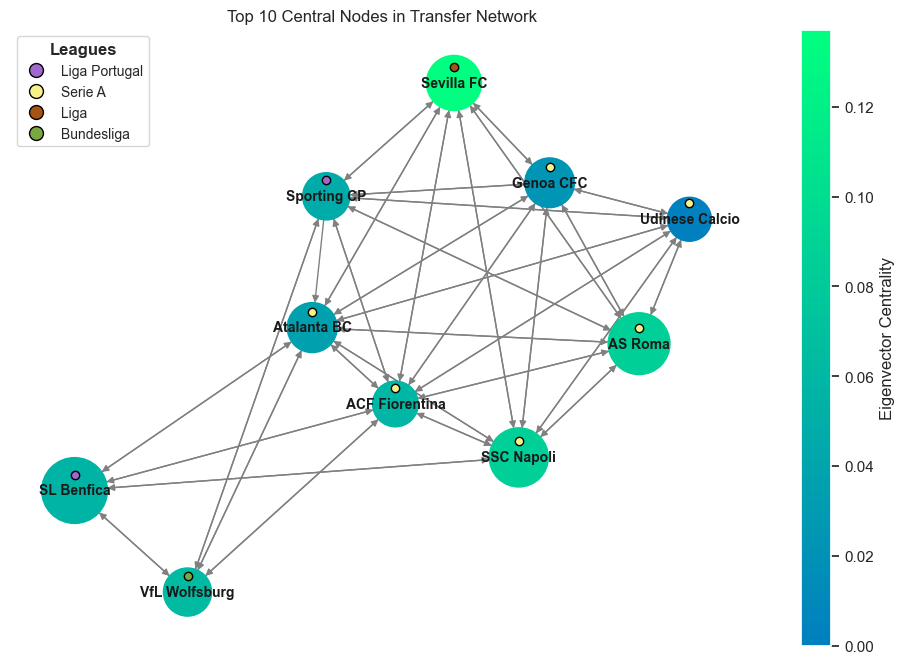

In [46]:
# Create a directed graph
G = nx.from_pandas_edgelist(transfers, source='team_name', target='counter_team_name', edge_attr='transfer_fee_amnt', create_using=nx.DiGraph())

# Compute the centrality metrics
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Add centrality measures as node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')

# Plot
temp = transfers[["team_name", "transfer_fee_amnt"]]
plot_subgraph(graph=G, sizes_df=temp, top_n_nodes=10, colormap="winter", legend_position="upper left")

**TOP CENTRAL TEAMS BY CENTRALITY IN CAPITAL GAIN**

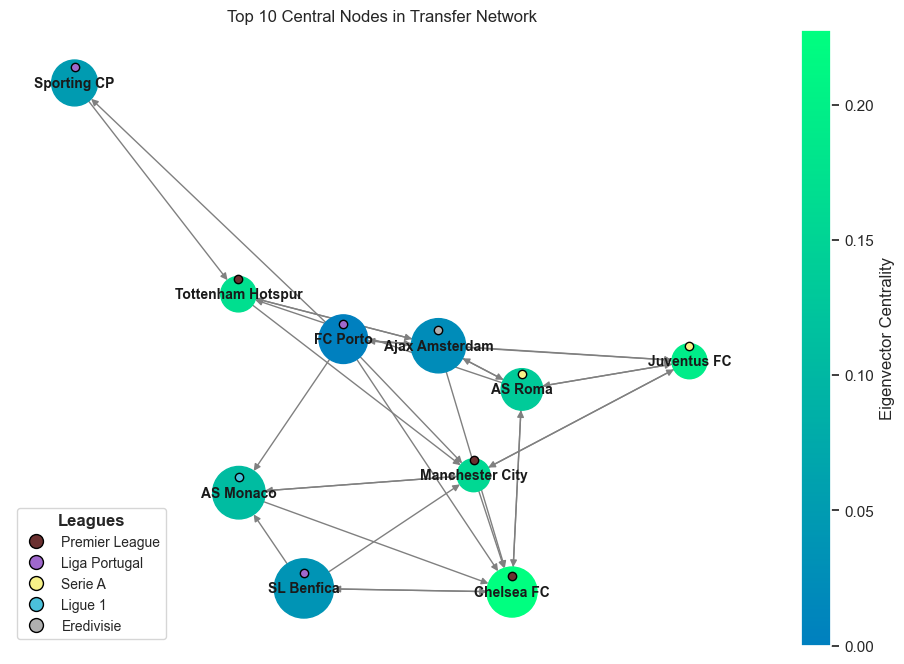

In [9]:
#Subset with positive gains only
gain = df_cg[df_cg["gain"]>0]

# Graph
G_cg = nx.from_pandas_edgelist(gain, source='team_name', target='counter_team_name_left', edge_attr='gain', create_using=nx.DiGraph())

# Metrics
degree_centrality = nx.degree_centrality(G_cg)
eigenvector_centrality = nx.eigenvector_centrality(G_cg, max_iter=1000)

nx.set_node_attributes(G_cg, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G_cg, eigenvector_centrality, 'eigenvector_centrality')

#Plot
temp = gain[["team_name", "gain"]]
temp = temp.rename(columns={"gain":"transfer_fee_amnt"})
plot_subgraph(graph=G_cg, sizes_df=temp, top_n_nodes=10, legend_position="lower left", colormap="winter", size_scale=500_000)

**COMMUNITIES**

!!! Il calcolo di Louvain non è deterministico. Nonostante sia stato impostato un random seed, i risultati possono variare ad ogni elaborazione.

In [ ]:
team_to_country = {}

for idx, row in df.iterrows():
    if row['team_name'] not in team_to_country:
        team_to_country[row['team_name']] = row['team_country']
    if row['counter_team_name'] not in team_to_country:
        team_to_country[row['counter_team_name']] = row['counter_team_country']

# Map team and country
for node in G_cg.nodes():
    if 'team_country' not in G_cg.nodes[node]:
        if node in team_to_country:
            G_cg.nodes[node]['team_country'] = team_to_country[node]
        else:
            G_cg.nodes[node]['team_country'] = 'Unknown'

# Central nodes
central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:100]
print(central_nodes)

subgraph = G_cg.subgraph(central_nodes)
sub_und = subgraph.to_undirected()

# Detect communities
partition = community.best_partition(sub_und, random_state=169)
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

print(communities)

['Chelsea FC', 'SL Benfica', 'Juventus FC', 'Sporting CP', 'AS Roma', 'Tottenham Hotspur', 'Manchester City', 'Ajax Amsterdam', 'AS Monaco', 'FC Porto', 'Sevilla FC', 'Atlético de Madrid', 'Borussia Dortmund', 'Arsenal FC', 'Olympique Lyon', 'PSV Eindhoven', 'Stade Rennais FC', 'VfL Wolfsburg', 'Paris Saint-Germain', 'FC Barcelona', 'TSG 1899 Hoffenheim', 'SSC Napoli', 'LOSC Lille', 'Liverpool FC', 'Udinese Calcio', 'Inter Milan', 'AC Milan', 'ACF Fiorentina', 'Real Madrid', 'Atalanta BC', 'OGC Nice', 'Bayer 04 Leverkusen', '1.FSV Mainz 05', 'US Sassuolo', 'SC Freiburg', 'AZ Alkmaar', 'Villarreal CF', 'Bayern Munich', 'Genoa CFC', 'Bologna FC 1909', 'SC Braga', 'Everton FC', 'Newcastle United', 'Olympique Marseille', 'West Ham United', 'VfB Stuttgart', 'Torino FC', 'Real Betis Balompié', 'Eintracht Frankfurt', 'Manchester United', 'FC Groningen', 'Borussia Mönchengladbach', 'FC Girondins Bordeaux', 'Southampton FC', 'Valencia CF', 'Feyenoord Rotterdam', 'SV Werder Bremen', 'RB Leipzig'

In [ ]:
from collections import Counter

pos = nx.spring_layout(G_cg, seed=42)

# Communities'colours
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

# Draw
for community_id, nodes in communities.items():
    lista_test = []
    for node in nodes:
        lista_test.append(G_cg.nodes[node]['team_country'])
    
    # Countries' distribution
    country_distribution = Counter(lista_test)
    print(f"COMMUNITY {community_id}:")
    for country, count in country_distribution.items():
        print(f"{country}: {count}")
    print()

COMMUNITY 0:
Italy: 20

COMMUNITY 1:
Germany: 17
England: 1
France: 1

COMMUNITY 2:
Netherlands: 9
England: 1

COMMUNITY 3:
France: 12
Spain: 13
Portugal: 5
England: 4

COMMUNITY 4:
England: 16
France: 1



Cohesion metrics for community 0:
 {'transitivity': 0.6697377746279235, 'density': 0.6368421052631579, 'assortativity': -0.027450213911874008, 'modularity': 0.09989071784714156, 'clustering': [('AS Roma', 0.7142857142857143), ('SS Lazio', 0.7142857142857143), ('ACF Fiorentina', 0.7121212121212122), ('Cagliari Calcio', 0.7090909090909091), ('UC Sampdoria', 0.7090909090909091), ('Torino FC', 0.7051282051282052), ('Genoa CFC', 0.6923076923076923), ('Juventus FC', 0.6923076923076923), ('SSC Napoli', 0.6857142857142857), ('Hellas Verona', 0.6666666666666666)]}


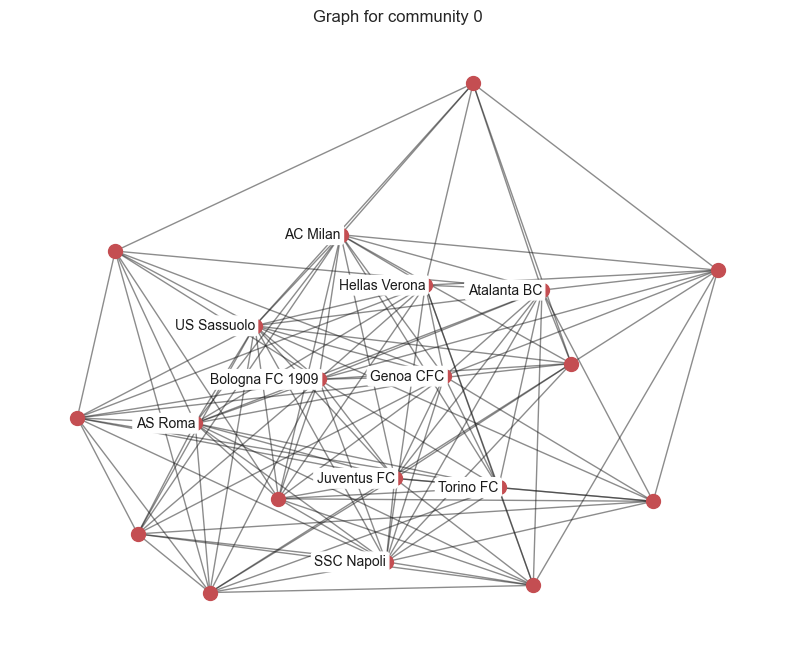

Cohesion metrics for community 1:
 {'transitivity': 0.580091533180778, 'density': 0.5380116959064327, 'assortativity': -0.13884555382215386, 'modularity': 0.11891540642722115, 'clustering': [('1. FC Köln', 0.8666666666666667), ('Leeds United', 0.8), ('FC Schalke 04', 0.8), ('Hamburger SV', 0.7142857142857143), ('Hertha BSC', 0.6388888888888888), ('Bayern Munich', 0.6111111111111112), ('1.FSV Mainz 05', 0.6060606060606061), ('Borussia Mönchengladbach', 0.6), ('VfB Stuttgart', 0.5833333333333334), ('Bayer 04 Leverkusen', 0.5818181818181818)]}


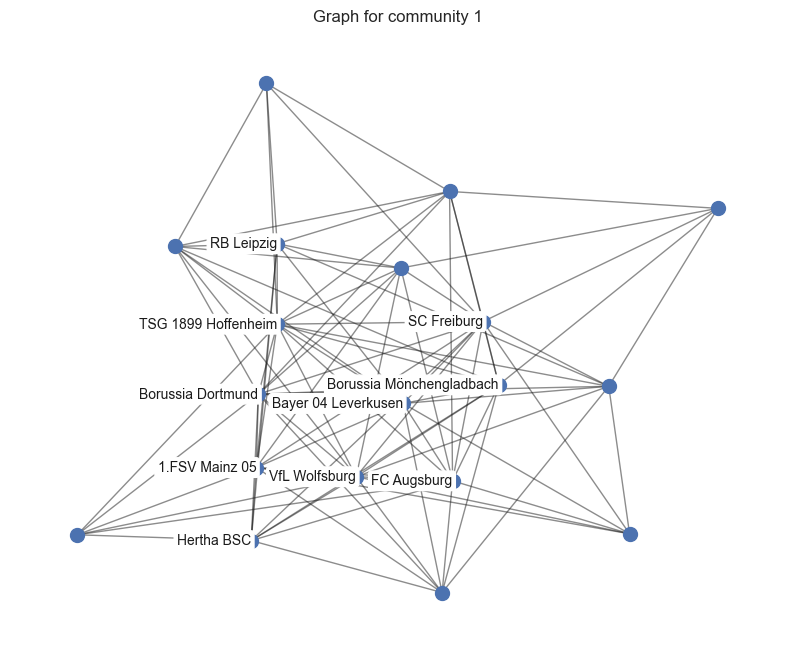

Cohesion metrics for community 2:
 {'transitivity': 0.5660377358490566, 'density': 0.6666666666666666, 'assortativity': -0.42857142857142827, 'modularity': 0.03944444444444439, 'clustering': [('FC Groningen', 0.7333333333333333), ('FC Utrecht', 0.7), ('SC Heerenveen', 0.7), ('Twente Enschede FC', 0.6666666666666666), ('AZ Alkmaar', 0.6428571428571429), ('PEC Zwolle', 0.5), ('Brighton & Hove Albion', 0.5), ('Ajax Amsterdam', 0.42857142857142855), ('Feyenoord Rotterdam', 0.42857142857142855), ('PSV Eindhoven', 0.42857142857142855)]}


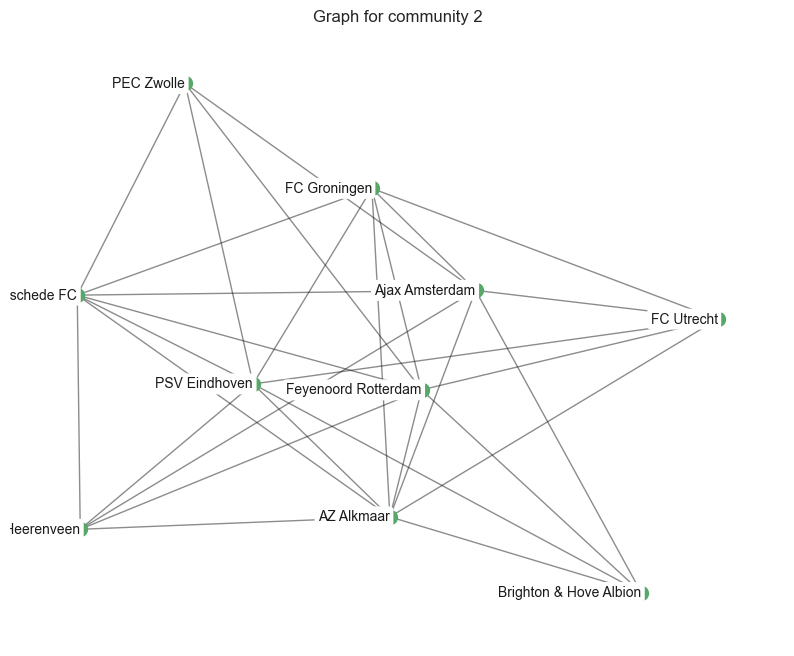

Cohesion metrics for community 3:
 {'transitivity': 0.39664804469273746, 'density': 0.33511586452762926, 'assortativity': -0.042254341512934425, 'modularity': 0.18989078768673612, 'clustering': [('Getafe CF', 0.5714285714285714), ('Manchester City', 0.5384615384615384), ('Celta de Vigo', 0.5), ('Real Sociedad', 0.5), ('FC Lorient', 0.5), ('AS Monaco', 0.475), ('SL Benfica', 0.4727272727272727), ('AS Saint-Étienne', 0.4722222222222222), ('Montpellier HSC', 0.4722222222222222), ('FC Nantes', 0.4666666666666667)]}


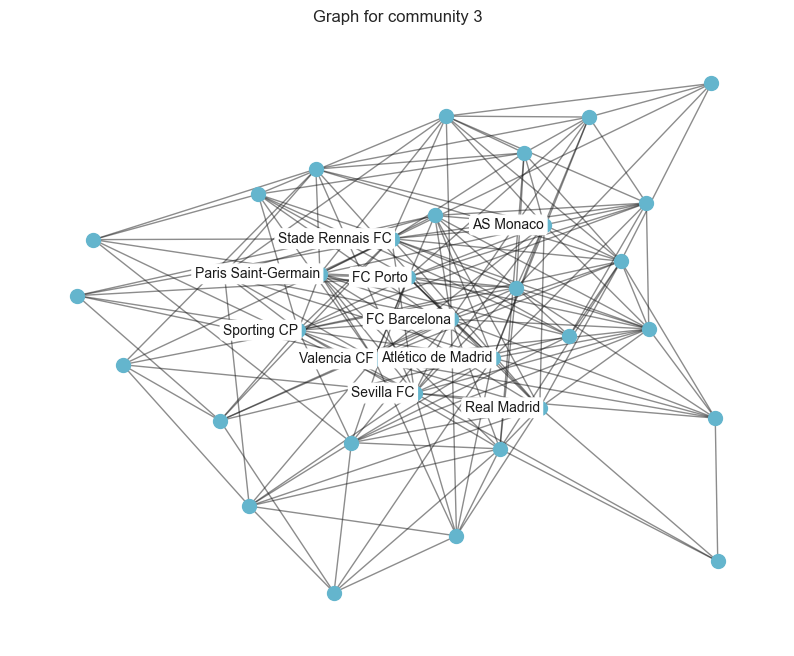

Cohesion metrics for community 4:
 {'transitivity': 0.49536178107606677, 'density': 0.5147058823529411, 'assortativity': -0.2614347616754957, 'modularity': 0.13642857142857145, 'clustering': [('Nottingham Forest', 1.0), ('LOSC Lille', 0.6190476190476191), ('Arsenal FC', 0.5833333333333334), ('Fulham FC', 0.5714285714285714), ('Aston Villa', 0.5555555555555556), ('Hull City', 0.5357142857142857), ('Swansea City', 0.5238095238095238), ('Sunderland AFC', 0.5238095238095238), ('Tottenham Hotspur', 0.5), ('Chelsea FC', 0.4727272727272727)]}


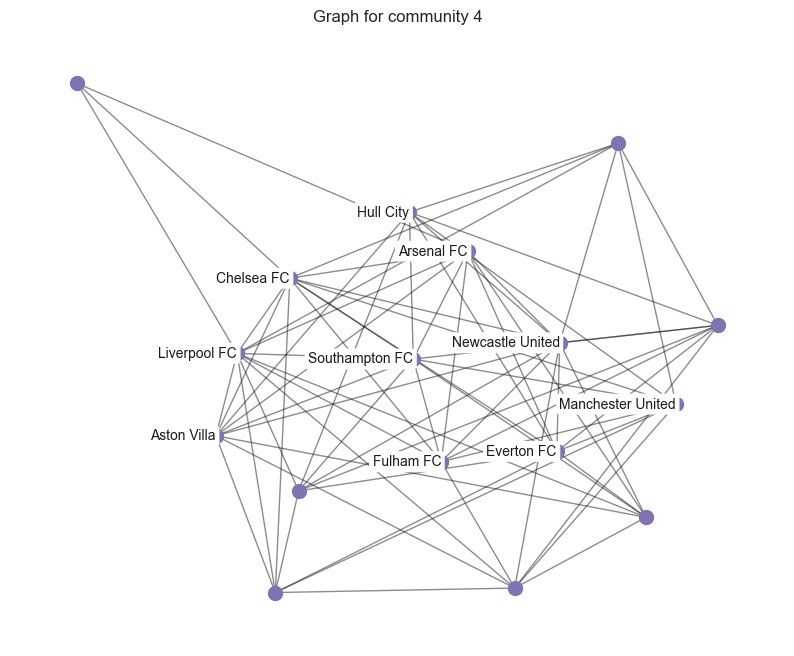

In [ ]:
for community_id, nodes in communities.items():
    subgraph_nodes = sub_und.subgraph(nodes)
    print(f"Cohesion metrics for community {community_id}:\n",cohesion_metrics(subgraph_nodes))
    
    degree_centralities = nx.degree_centrality(subgraph_nodes)
    sorted_nodes = sorted(degree_centralities, key=degree_centralities.get, reverse=True)[:10]

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph_nodes, seed=42)
    nx.draw_networkx_nodes(subgraph_nodes, pos, node_color=colors[community_id % len(colors)], label=f'Community {community_id}', node_size=100)
    nx.draw_networkx_edges(subgraph_nodes, pos, alpha=0.5)
    
    # Normal
    #nx.draw_networkx_labels(subgraph_nodes, pos, font_size=10)

    # With boxes
    # nx.draw_networkx_labels(subgraph_nodes, pos, font_size=9, horizontalalignment="right",
    #                         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2'))

    #With boxes - subset
    labels = {node: str(node) for node in subgraph.nodes if node in sorted_nodes}
    nx.draw_networkx_labels(subgraph_nodes, pos, labels, font_size=10, horizontalalignment="right",
                            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2'))
    
    plt.title(f'Graph for community {community_id}')
    plt.axis('off')
    plt.show()

**AGENTS**

In [8]:
G_cg_a = nx.from_pandas_edgelist(df_cg_a, source='team_name', target='agent_left', edge_attr='gain', create_using=nx.DiGraph())

degree_centrality = nx.degree_centrality(G_cg_a)
eigenvector_centrality = nx.eigenvector_centrality(G_cg_a, max_iter=1000)

nx.set_node_attributes(G_cg_a, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G_cg_a, eigenvector_centrality, 'eigenvector_centrality')

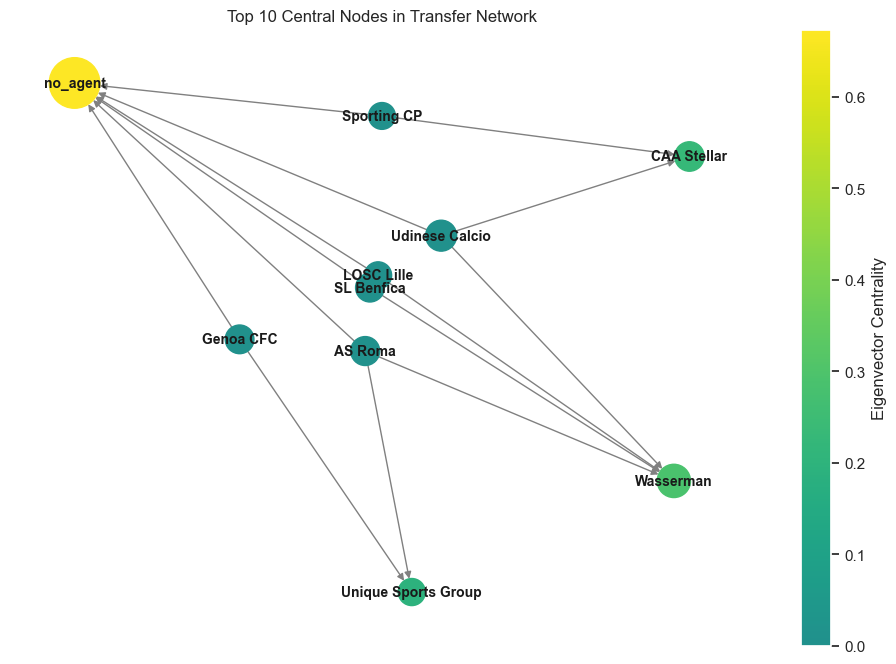

In [24]:
plot_subgraph(graph=G_cg_a, top_n_nodes=10, colormap="viridis", legend_position="upper left", league_dot=False)

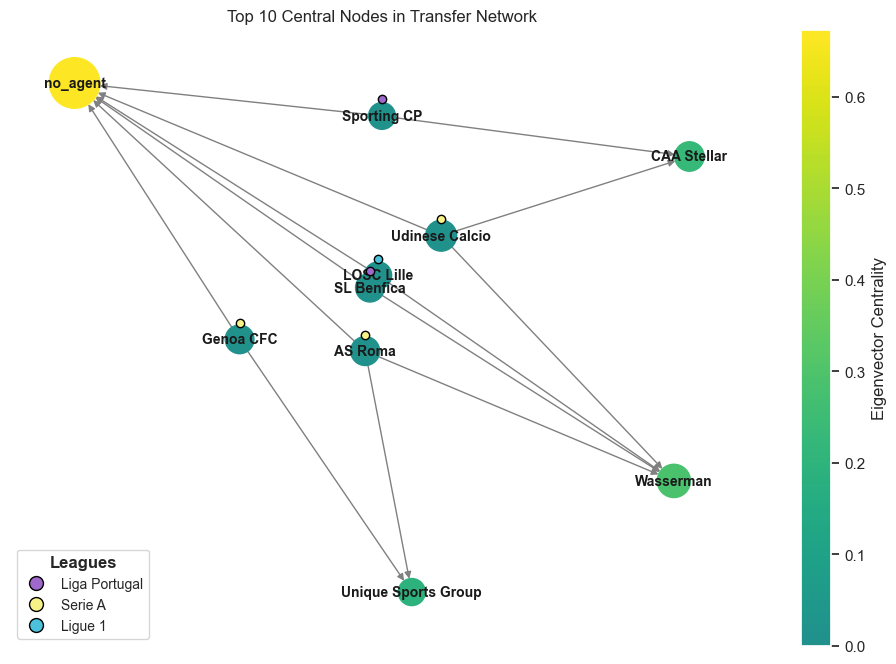

In [11]:
plot_subgraph(graph=G_cg_a, top_n_nodes=10, colormap="viridis", legend_position="lower left")

Agents' count

In [26]:
agents = agents[agents["counter_team_name"] != "Without Club"]
players = agents[['agent', 'player_id']].drop_duplicates()['agent'].value_counts().reset_index()
players.head(5)

,agent,count
0,no_agent,4194
1,Wasserman,254
2,CAA Stellar,189
3,Unique Sports Group,141
4,CAA Base Ltd,113


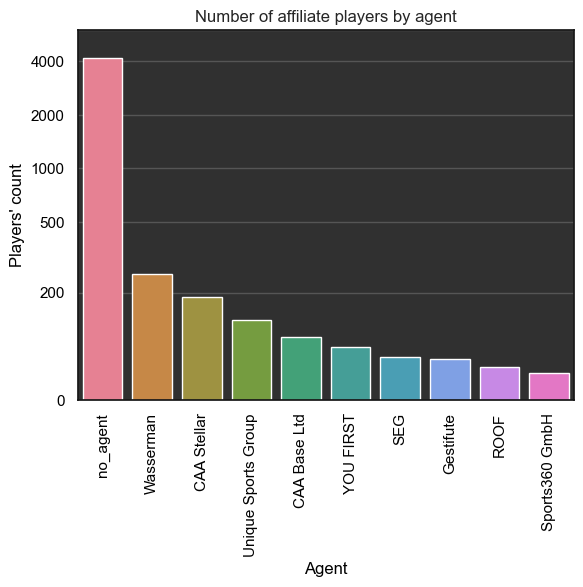

In [28]:
load_theme("light")

sns.barplot(players.head(10), x='agent', y='count', palette='husl', hue='agent')
plt.title(f"Number of affiliate players by agent")
plt.yscale('log')
plt.xlabel("Agent")
plt.ylabel("Players' count")
plt.xticks(rotation=90)
plt.yticks([50, 200, 500, 1000, 2000, 4000, 6000], [0, 200, 500, 1000, 2000, 4000, None])
plt.show()

**RELATIONSHIP BETWEEN CAPITAL GAINS AND TEAMS' PERFORMANCES**

In [5]:
def normalize(values):
   min_val = min(values)
   max_val = max(values)
   return [(x - min_val) / (max_val - min_val) for x in values]


def plot_comparision(team_name:str, df: pd.DataFrame, line_colors:list=["pink", "lightgreen"]):
   team = df[df["team_name"] == team_name]

   team_perf = team[['performance_09/10', 'performance_10/11',
      'performance_11/12', 'performance_12/13', 'performance_13/14',
      'performance_14/15', 'performance_15/16', 'performance_16/17',
      'performance_17/18', 'performance_18/19', 'performance_19/20',
      'performance_20/21', 'performance_21/22', 'performance_22/23',
      'performance_23/24']].values[0]

   team_gains = list(team[['gain_09/10', 'gain_10/11',
      'gain_11/12', 'gain_12/13', 'gain_13/14', 'gain_14/15', 'gain_15/16',
      'gain_16/17', 'gain_17/18', 'gain_18/19', 'gain_19/20', 'gain_20/21',
      'gain_21/22', 'gain_22/23', 'gain_23/24']].values[0])
   team_gains.append(0)
   
   jumps = team[['jump_09/10', 'jump_10/11',
      'jump_11/12', 'jump_12/13', 'jump_13/14', 'jump_14/15', 'jump_15/16',
      'jump_16/17', 'jump_17/18', 'jump_18/19', 'jump_19/20', 'jump_20/21',
      'jump_21/22', 'jump_22/23']].values[0]

   seasons = ['09/10', '10/11', '11/12', '12/13', '13/14', '14/15', '15/16', '16/17', '17/18', '18/19', '19/20', '20/21', '21/22', '22/23', '23/24']
   team_gains = normalize(team_gains)
   zero_loc =  team_gains.pop(-1)

   load_theme("light")
   sns.lineplot(x=seasons, y=team_perf, color=line_colors[0])
   sns.lineplot(x=seasons, y=team_gains, color=line_colors[1])

   # Legend
   legend_elements = [
                        Line2D([0], [0], marker='o', color='w', markerfacecolor=line_colors[0], markersize=10),
                        Line2D([0], [0], marker='o', color='w', markerfacecolor=line_colors[1], markersize=10),
                        Line2D([0], [0], color='#de9e14', linestyle='--', linewidth=1),
                        Line2D([0], [0], color='#de1414', linestyle='--', linewidth=1),
                        Line2D([0], [0], color='white', linestyle='--', linewidth=1)
                     ]
   
   legend = plt.legend(handles=legend_elements, title=None, loc='upper left', labels=["Performance", "Gain", "Promotion", "Relegation", "Zero gain"])
   plt.setp(legend.get_texts(), color='white')
   legend.get_title().set_color('white')

   promotions = [season for season, jump in zip(seasons[:-1], jumps) if jump==1]
   relegations = [season for season, jump in zip(seasons[:-1], jumps) if jump==-1]
   for season in promotions:
      plt.axvline(x=season, color='#de9e14', linestyle='--', linewidth=1)

   for season in relegations:
      plt.axvline(x=season, color='#de1414', linestyle='--', linewidth=1)
   
   plt.axhline(y=zero_loc, color='white', linestyle='--', linewidth=1)

   plt.title(f"Performance and Gain comparision by year for {team_name}")
   plt.ylabel("Performance / Normalized gain")
   plt.xlabel("Season")
   plt.xticks(rotation=90)
   plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
   plt.show()

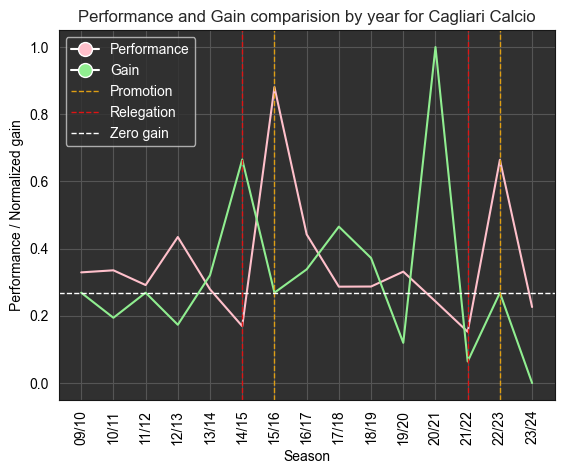

In [6]:
plot_comparision("Cagliari Calcio", perf)

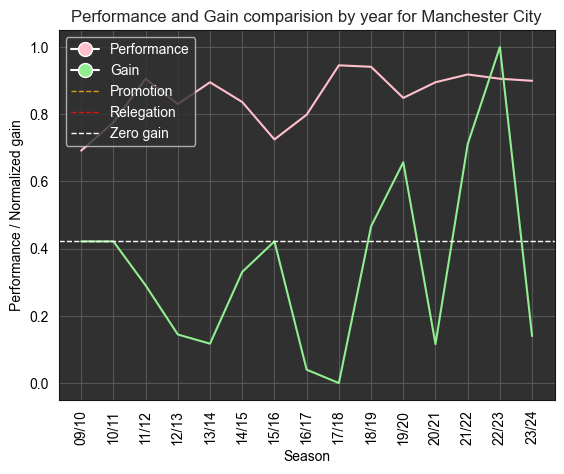

In [7]:
plot_comparision("Manchester City", perf)

**OLS Models**

In [9]:
total_gains = perf[['gain_09/10', 'gain_10/11',
       'gain_11/12', 'gain_12/13', 'gain_13/14', 'gain_14/15', 'gain_15/16',
       'gain_16/17', 'gain_17/18', 'gain_18/19', 'gain_19/20', 'gain_20/21',
       'gain_21/22', 'gain_22/23', 'gain_23/24']].values.tolist()

total_performance = perf[['performance_09/10', 'performance_10/11',
       'performance_11/12', 'performance_12/13', 'performance_13/14',
       'performance_14/15', 'performance_15/16', 'performance_16/17',
       'performance_17/18', 'performance_18/19', 'performance_19/20',
       'performance_20/21', 'performance_21/22', 'performance_22/23',
       'performance_23/24']].values.tolist()

flat_total_gains = [item for sublist in total_gains for item in sublist]
flat_total_performance = [item for sublist in total_performance for item in sublist]

Linear

In [10]:
X = sm.add_constant(flat_total_gains)
model = sm.OLS(flat_total_performance, X)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     40.09
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.71e-10
Time:                        13:29:03   Log-Likelihood:                -242.56
No. Observations:                3855   AIC:                             489.1
Df Residuals:                    3853   BIC:                             501.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4739      0.004    111.898      0.0

Polynomial (degree = 2)

In [11]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(np.array(flat_total_gains).reshape(-1, 1))

model_2 = LinearRegression()
model_2.fit(X_poly, flat_total_performance)

predictions_2 = model_2.predict(X_poly)
coefficients_2 = model_2.coef_
intercept_2 = model_2.intercept_

x_values = np.linspace(min(flat_total_gains), max(flat_total_gains), 100)
y_values = intercept_2
for i, coef in enumerate(coefficients_2[1:], start=1):
    y_values += coef * x_values**i

print("METRICS:")
print("R-squared:", model_2.score(X_poly, flat_total_performance))
print("Mean Squared Error:", mean_squared_error(flat_total_performance, predictions_2))

print("\nCOEFFICIENTS:")
for i, coef in enumerate(coefficients_2):
    print(f"Coefficient {i}: {coef}")
print("Intercept:", intercept_2)


METRICS:
R-squared: 0.01608132951942043
Mean Squared Error: 0.06601327661541949

COEFFICIENTS:
Coefficient 0: 0.0
Coefficient 1: 8.593467507901871e-10
Coefficient 2: 1.0955819339868225e-17
Intercept: 0.4727475865366881


Polynomial (degree = 3)

In [12]:
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(np.array(flat_total_gains).reshape(-1, 1))

model_3 = LinearRegression()
model_3.fit(X_poly, flat_total_performance)

predictions_3 = model_3.predict(X_poly)
coefficients_3 = model_3.coef_
intercept_3 = model_3.intercept_

x_values = np.linspace(min(flat_total_gains), max(flat_total_gains), 100)
y_values = intercept_3
for i, coef in enumerate(coefficients_3[1:], start=1):
    y_values += coef * x_values**i

print("METRICS:")
print("R-squared:", model_3.score(X_poly, flat_total_performance))
print("Mean Squared Error:", mean_squared_error(flat_total_performance, predictions_3))

print("\nCOEFFICIENTS:")
for i, coef in enumerate(coefficients_3):
    print(f"Coefficient {i}: {coef}")
print("Intercept:", intercept_3)


METRICS:
R-squared: 0.014313448406776619
Mean Squared Error: 0.0661318876636834

COEFFICIENTS:
Coefficient 0: 0.0
Coefficient 1: 6.552366426914158e-26
Coefficient 2: 1.6388731051088433e-17
Coefficient 3: -2.3465400848925135e-26
Intercept: 0.47450828588847166


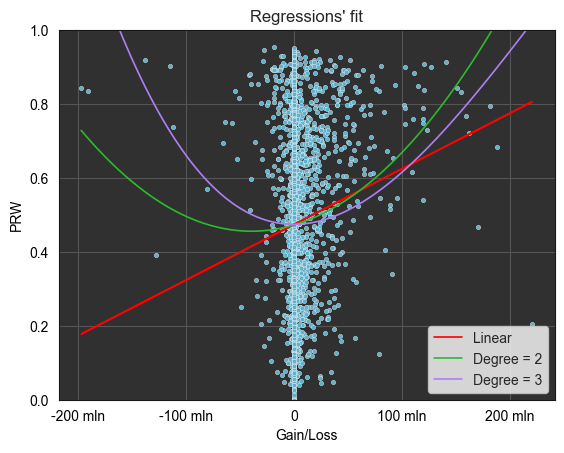

In [14]:
x_values_2 = np.linspace(min(flat_total_gains), max(flat_total_gains), 100)
y_values_2 = intercept_2
for i, coef in enumerate(coefficients_2[1:], start=1):
    y_values_2 += coef * x_values_2**i

x_values_3 = np.linspace(min(flat_total_gains), max(flat_total_gains), 100)
y_values_3 = intercept_3
for i, coef in enumerate(coefficients_3[1:], start=1):
    y_values_3 += coef * x_values_3**i

linewidth=1.2
sns.scatterplot(x=flat_total_gains, y=flat_total_performance, color="#60b1cc", s=10, legend=False)
plt.plot(flat_total_gains, results.predict(), color='red', linewidth=linewidth, label='Linear')
plt.plot(x_values_2, y_values_2, color='#2dba2d', linewidth=linewidth, label='Degree = 2')
plt.plot(x_values_3, y_values_3, color='#ae7ff5', linewidth=linewidth, label='Degree = 3')
plt.title("Regressions' fit")
plt.ylabel("PRW")
plt.xlabel("Gain/Loss")
plt.ylim(0, 1)
plt.xticks([-200_000_000, -100_000_000, 0, 100_000_000, 200_000_000], ["-200 mln", "-100 mln", "0", "100 mln", "200 mln"])
legend = plt.legend(facecolor='white', fontsize=10)
plt.show()

**LEAGUES**

In [29]:
df = pd.read_csv('dataset/transfers_complete.csv')
df = df[df["is_free"] == False]
df = df[df["is_loan"] == False]
df = df[df["is_loan_end"] == False]
df = df[df["is_retired"] == False]
df = df[df["counter_team_name"] != "Without Club"]

In only

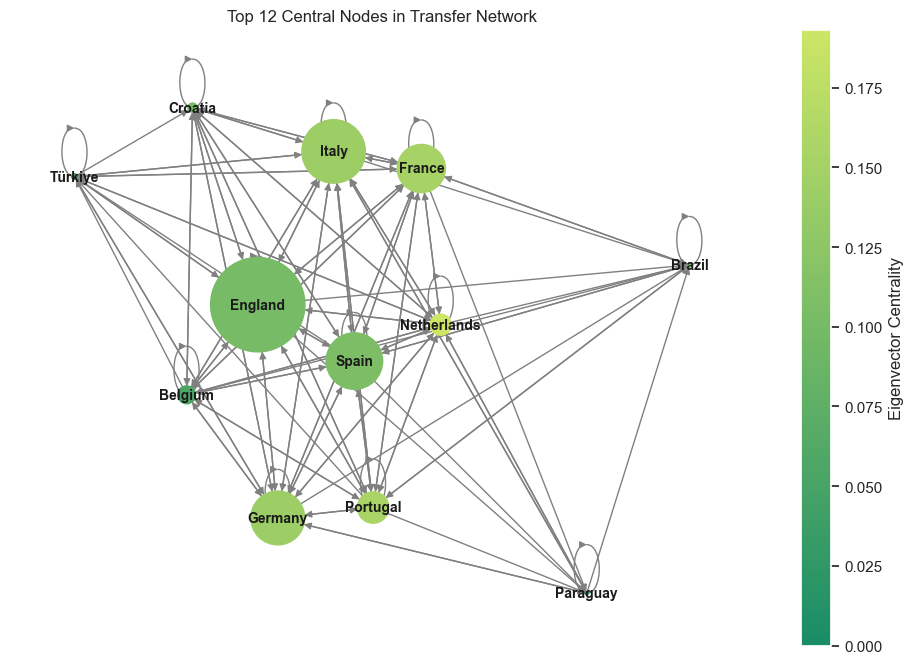

In [44]:
df_filtered = df[df["dir"] == "in"]
transfers_leagues = df_filtered[['team_country', 'counter_team_country', 'transfer_fee_amnt']]
G_leagues = nx.from_pandas_edgelist(transfers_leagues, source='team_country', target='counter_team_country', edge_attr='transfer_fee_amnt', create_using=nx.DiGraph())

degree_centrality = nx.degree_centrality(G_leagues)
eigenvector_centrality = nx.eigenvector_centrality(G_leagues, max_iter=1000)

nx.set_node_attributes(G_leagues, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G_leagues, eigenvector_centrality, 'eigenvector_centrality')

central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:12]

temp = transfers_leagues.rename(columns={"team_country": "team_name"}).drop(columns="counter_team_country")
plot_subgraph(graph=G_leagues, top_n_nodes=12, sizes_df=temp, colormap="summer", truncate_cmap=(0.10, 0.8), legend_position="upper left",
              size_scale=5_000_000, size_multiplier=30_000_000, league_dot=False)

Out only

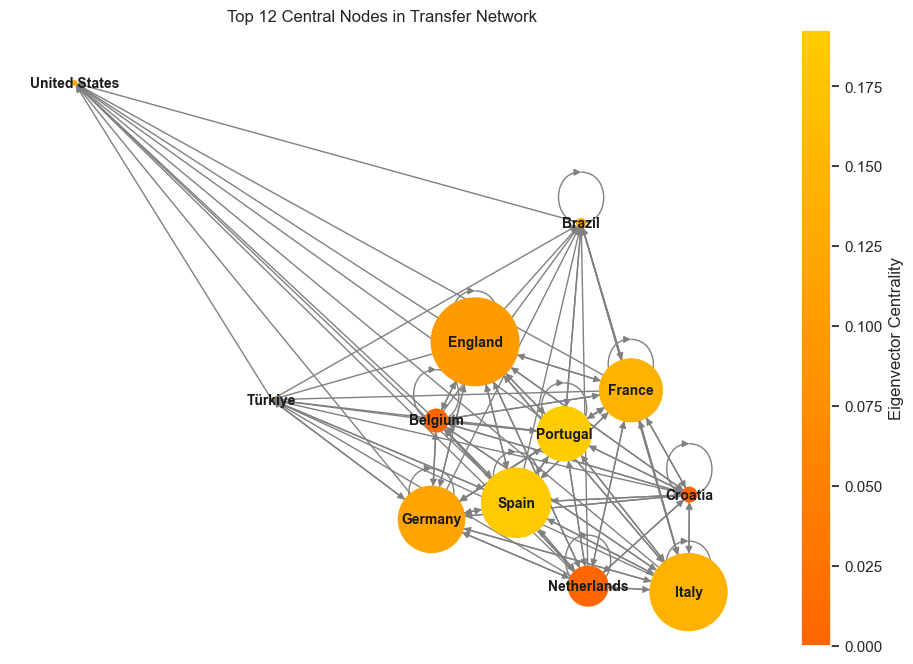

In [42]:
df_filtered = df[df["dir"] == "left"]
transfers_leagues = df_filtered[['team_country', 'counter_team_country', 'transfer_fee_amnt']]
G_leagues = nx.from_pandas_edgelist(transfers_leagues, source='team_country', target='counter_team_country', edge_attr='transfer_fee_amnt', create_using=nx.DiGraph())

degree_centrality = nx.degree_centrality(G_leagues)
eigenvector_centrality = nx.eigenvector_centrality(G_leagues, max_iter=1000)

nx.set_node_attributes(G_leagues, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G_leagues, eigenvector_centrality, 'eigenvector_centrality')

central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:12]

temp = transfers_leagues.rename(columns={"team_country": "team_name"}).drop(columns="counter_team_country")
plot_subgraph(graph=G_leagues, top_n_nodes=12, sizes_df=temp, colormap="autumn", truncate_cmap=(0.4, 0.8), legend_position="upper left",
              size_scale=3_000_000, size_multiplier=30_000_000, league_dot=False)